# Experiment Results Visualization

This notebook visualizes all 5 experiment runs:
1. **Centralized Training** — 25 epochs, full dataset
2. **SA-Drift (α=1.0, K=3)** — Near-IID, drift-aware aggregation
3. **FedAvg (α=1.0, K=3)** — Near-IID, standard FedAvg
4. **SA-Drift (α=0.5, K=5)** — Non-IID, drift-aware aggregation
5. **FedAvg (α=0.5, K=5)** — Non-IID, standard FedAvg

In [2]:
import re
import zipfile
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({
    'figure.figsize': (14, 5),
    'font.size': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

## Helper: Parse Log Files

In [3]:
def parse_centralized_log(path):
    """Parse centralized training log and return per-epoch metrics."""
    epochs, train_loss, val_acc, bal_acc = [], [], [], []
    per_class = []
    with open(path) as f:
        lines = f.readlines()
    for line in lines:
        m = re.search(r'Epoch\s+(\d+)/\d+.*?Train Loss=([\d.]+).*?Acc=([\d.]+)\s+BalAcc=([\d.]+)', line)
        if m:
            epochs.append(int(m.group(1)))
            train_loss.append(float(m.group(2)))
            val_acc.append(float(m.group(3)))
            bal_acc.append(float(m.group(4)))
    return {
        'epoch': epochs,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'bal_acc': bal_acc,
    }


def parse_federated_log(path):
    """Parse federated training log and return per-round metrics."""
    rounds, global_acc, bal_acc, f1, auc = [], [], [], [], []
    worst_acc, std_acc = [], []
    with open(path) as f:
        lines = f.readlines()
    for line in lines:
        m = re.search(
            r'Round\s+(\d+)/\d+.*?Global Acc=([\d.]+)\s+BalAcc=([\d.]+)\s+F1=([\d.]+)\s+AUC=([\d.]+)'
            r'.*?Worst Acc=([\d.]+).*?Std Acc=([\d.]+)',
            line
        )
        if m:
            rounds.append(int(m.group(1)))
            global_acc.append(float(m.group(2)))
            bal_acc.append(float(m.group(3)))
            f1.append(float(m.group(4)))
            auc.append(float(m.group(5)))
            worst_acc.append(float(m.group(6)))
            std_acc.append(float(m.group(7)))
    return {
        'round': rounds,
        'global_acc': global_acc,
        'bal_acc': bal_acc,
        'f1': f1,
        'auc': auc,
        'worst_acc': worst_acc,
        'std_acc': std_acc,
    }


def parse_docx_log(path):
    """Parse the SA-Drift (α=1.0, K=3) docx log file."""
    with zipfile.ZipFile(path) as z:
        content = z.read('word/document.xml').decode('utf-8')
    text = re.sub(r'<[^>]+>', ' ', content)
    text = re.sub(r'\s+', ' ', text)

    rounds, global_acc, bal_acc, f1, auc = [], [], [], [], []
    worst_acc, std_acc = [], []

    # Format 1: Rounds 1-15 (pipe-separated)
    for m in re.finditer(
        r'Round\s+(\d+)/25\s*\|\s*Global Acc=([\d.]+)\s+BalAcc=([\d.]+)\s+F1=([\d.]+)\s+AUC=([\d.]+)'
        r'.*?Worst Acc=([\d.]+).*?Std Acc=([\d.]+)',
        text
    ):
        rn = int(m.group(1))
        if rn not in rounds:  # avoid duplicates
            rounds.append(rn)
            global_acc.append(float(m.group(2)))
            bal_acc.append(float(m.group(3)))
            f1.append(float(m.group(4)))
            auc.append(float(m.group(5)))
            worst_acc.append(float(m.group(6)))
            std_acc.append(float(m.group(7)))

    # Round 16 (no "Round 16/25" label — extracted manually from between R15 and R17)
    r16_match = re.search(
        r'New best global balanced accuracy: 0\.7768.*?'
        r'Acc:\s*([\d.]+)\s*BalAcc:\s*([\d.]+)\s*F1:\s*([\d.]+)\s*AUC:\s*([\d.]+)'
        r'.*?Worst Acc:\s*([\d.]+).*?Std Acc:\s*([\d.]+)',
        text
    )
    if r16_match and 16 not in rounds:
        rounds.append(16)
        global_acc.append(float(r16_match.group(1)))
        bal_acc.append(float(r16_match.group(2)))
        f1.append(float(r16_match.group(3)))
        auc.append(float(r16_match.group(4)))
        worst_acc.append(float(r16_match.group(5)))
        std_acc.append(float(r16_match.group(6)))

    # Format 2: Rounds 17-24 (colon-separated)
    for m in re.finditer(
        r'Round\s+(\d+)/25\s+Global Acc:\s*([\d.]+).*?BalAcc:\s*([\d.]+).*?F1:\s*([\d.]+).*?AUC:\s*([\d.]+)'
        r'.*?Worst Acc:\s*([\d.]+).*?Std Acc:\s*([\d.]+)',
        text
    ):
        rn = int(m.group(1))
        if rn not in rounds:
            rounds.append(rn)
            global_acc.append(float(m.group(2)))
            bal_acc.append(float(m.group(3)))
            f1.append(float(m.group(4)))
            auc.append(float(m.group(5)))
            worst_acc.append(float(m.group(6)))
            std_acc.append(float(m.group(7)))

    # Round 25 (Final — different format)
    r25 = re.search(
        r'Round\s+25/25\s*\(Final\)\s*Global Acc:\s*([\d.]+)\s*Global BalAcc:\s*([\d.]+)'
        r'\s*F1:\s*([\d.]+)\s*AUC:\s*([\d.]+)'
        r'\s*Worst Acc:\s*([\d.]+).*?Std Acc:\s*([\d.]+)',
        text
    )
    if r25 and 25 not in rounds:
        rounds.append(25)
        global_acc.append(float(r25.group(1)))
        bal_acc.append(float(r25.group(2)))
        f1.append(float(r25.group(3)))
        auc.append(float(r25.group(4)))
        worst_acc.append(float(r25.group(5)))
        std_acc.append(float(r25.group(6)))

    # Sort by round number
    order = sorted(range(len(rounds)), key=lambda i: rounds[i])
    return {
        'round': [rounds[i] for i in order],
        'global_acc': [global_acc[i] for i in order],
        'bal_acc': [bal_acc[i] for i in order],
        'f1': [f1[i] for i in order],
        'auc': [auc[i] for i in order],
        'worst_acc': [worst_acc[i] for i in order],
        'std_acc': [std_acc[i] for i in order],
    }

## Load All Experiment Data

In [4]:
# 1. Centralized Training
centralized = parse_centralized_log('logs/train_20260224_020732.log')

# 2. SA-Drift (α=1.0, K=3) — from docx
sa_drift_near_iid = parse_docx_log('logs/a = 1 drift = true.docx')

# 3. FedAvg (α=1.0, K=3)
fedavg_near_iid = parse_federated_log('logs/federated_20260223_112650.log')

# 4. SA-Drift (α=0.5, K=5)
sa_drift_non_iid = parse_federated_log('logs/federated_20260224_123351.log')

# 5. FedAvg (α=0.5, K=5)
fedavg_non_iid = parse_federated_log('logs/federated_20260223_113607.log')

print(f'Centralized: {len(centralized["epoch"])} epochs')
print(f'SA-Drift (α=1.0, K=3): {len(sa_drift_near_iid["round"])} rounds — {sa_drift_near_iid["round"]}')
print(f'FedAvg  (α=1.0, K=3): {len(fedavg_near_iid["round"])} rounds')
print(f'SA-Drift (α=0.5, K=5): {len(sa_drift_non_iid["round"])} rounds')
print(f'FedAvg  (α=0.5, K=5): {len(fedavg_non_iid["round"])} rounds')

Centralized: 25 epochs
SA-Drift (α=1.0, K=3): 25 rounds — [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
FedAvg  (α=1.0, K=3): 25 rounds
SA-Drift (α=0.5, K=5): 25 rounds
FedAvg  (α=0.5, K=5): 25 rounds


---
## Graph 1: Centralized Training (25 Epochs)

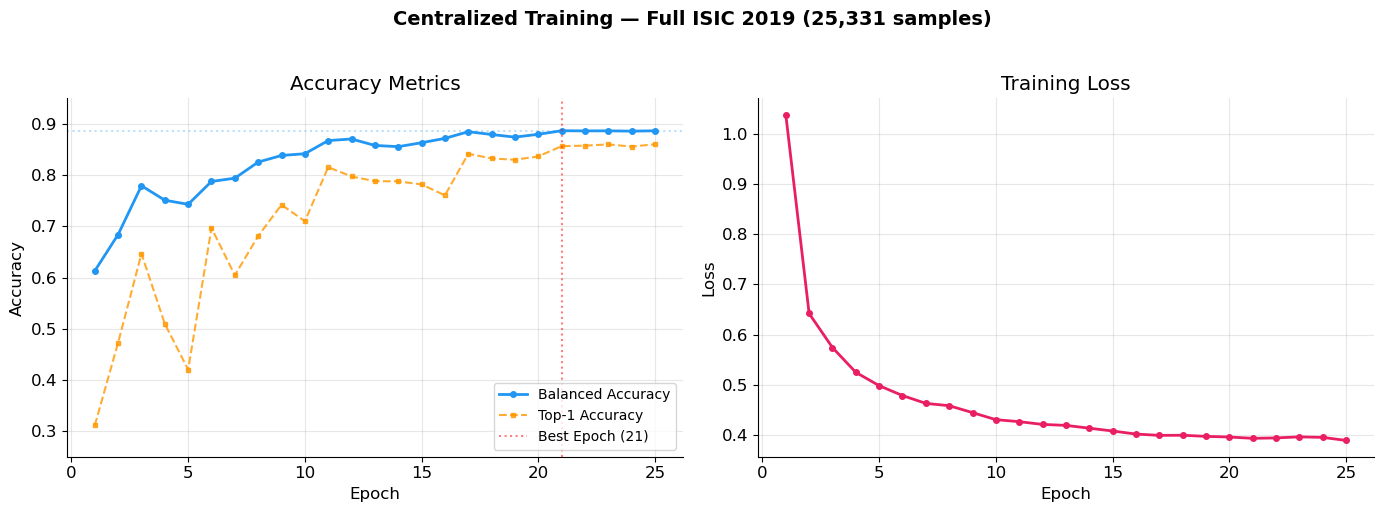

Peak Balanced Accuracy: 0.8867 at Epoch 21


In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Accuracy metrics
ax1.plot(centralized['epoch'], centralized['bal_acc'], 'o-', color='#2196F3', label='Balanced Accuracy', linewidth=2, markersize=4)
ax1.plot(centralized['epoch'], centralized['val_acc'], 's--', color='#FF9800', label='Top-1 Accuracy', linewidth=1.5, markersize=3, alpha=0.8)
best_epoch = centralized['bal_acc'].index(max(centralized['bal_acc'])) 
ax1.axvline(x=centralized['epoch'][best_epoch], color='red', linestyle=':', alpha=0.5, label=f'Best Epoch ({centralized["epoch"][best_epoch]})')
ax1.axhline(y=max(centralized['bal_acc']), color='#2196F3', linestyle=':', alpha=0.3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Metrics')
ax1.legend(loc='lower right', fontsize=10)
ax1.set_ylim(0.25, 0.95)

# Right: Training Loss
ax2.plot(centralized['epoch'], centralized['train_loss'], 'o-', color='#E91E63', linewidth=2, markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss')

fig.suptitle('Centralized Training — Full ISIC 2019 (25,331 samples)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/centralized_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Peak Balanced Accuracy: {max(centralized["bal_acc"]):.4f} at Epoch {centralized["epoch"][best_epoch]}')

---
## Graph 2: SA-Drift (α=1.0, K=3) — Near-IID with Drift Weighting

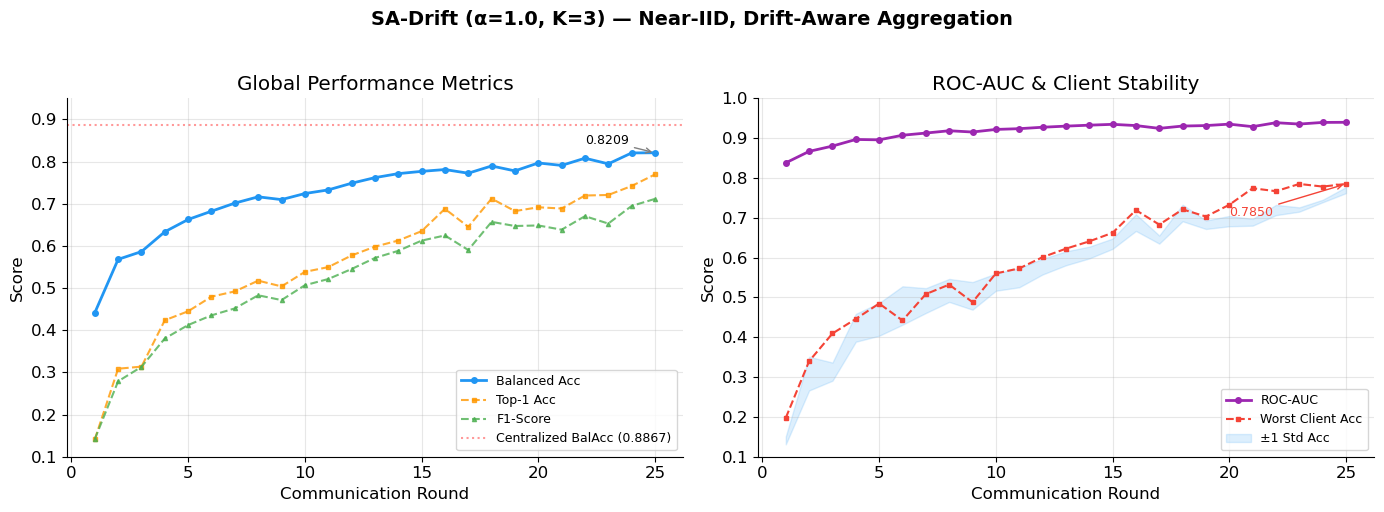

Peak Balanced Accuracy: 0.8209 at Round 25
Final Worst Client Acc: 0.7850 | Final Std Acc: 0.0076


In [15]:
d = sa_drift_near_iid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(d['round'], d['bal_acc'], 'o-', color='#2196F3', label='Balanced Acc', linewidth=2, markersize=4)
ax1.plot(d['round'], d['global_acc'], 's--', color='#FF9800', label='Top-1 Acc', linewidth=1.5, markersize=3, alpha=0.8)
ax1.plot(d['round'], d['f1'], '^--', color='#4CAF50', label='F1-Score', linewidth=1.5, markersize=3, alpha=0.8)
ax1.axhline(y=0.8867, color='red', linestyle=':', alpha=0.4, label='Centralized BalAcc (0.8867)')
best_idx = d['bal_acc'].index(max(d['bal_acc']))
ax1.annotate(f'{max(d["bal_acc"]):.4f}', xy=(d['round'][best_idx], max(d['bal_acc'])),
             xytext=(d['round'][best_idx]-3, max(d['bal_acc'])+0.02),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)
ax1.set_xlabel('Communication Round')
ax1.set_ylabel('Score')
ax1.set_title('Global Performance Metrics')
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim(0.1, 0.95)

ax2.plot(d['round'], d['auc'], 'o-', color='#9C27B0', label='ROC-AUC', linewidth=2, markersize=4)
ax2.plot(d['round'], d['worst_acc'], 's--', color='#F44336', label='Worst Client Acc', linewidth=1.5, markersize=3)
worst_final_idx = len(d['worst_acc']) - 1
ax2.annotate(f'{d["worst_acc"][worst_final_idx]:.4f}', xy=(d['round'][worst_final_idx], d['worst_acc'][worst_final_idx]),
             xytext=(d['round'][worst_final_idx]-5, d['worst_acc'][worst_final_idx]-0.08),
             arrowprops=dict(arrowstyle='->', color='#F44336'), fontsize=9, color='#F44336')
ax2.fill_between(d['round'],
                 [a - s for a, s in zip(d['global_acc'], d['std_acc'])],
                 [a + s for a, s in zip(d['global_acc'], d['std_acc'])],
                 alpha=0.15, color='#2196F3', label='±1 Std Acc')
ax2.set_xlabel('Communication Round')
ax2.set_ylabel('Score')
ax2.set_title('ROC-AUC & Client Stability')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_ylim(0.1, 1.0)

fig.suptitle('SA-Drift (α=1.0, K=3) — Near-IID, Drift-Aware Aggregation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plt.savefig('images/sa_drift_near_iid_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Peak Balanced Accuracy: {max(d["bal_acc"]):.4f} at Round {d["round"][best_idx]}')
print(f'Final Worst Client Acc: {d["worst_acc"][-1]:.4f} | Final Std Acc: {d["std_acc"][-1]:.4f}')

---
## Graph 3: FedAvg (α=1.0, K=3) — Near-IID, Standard Aggregation

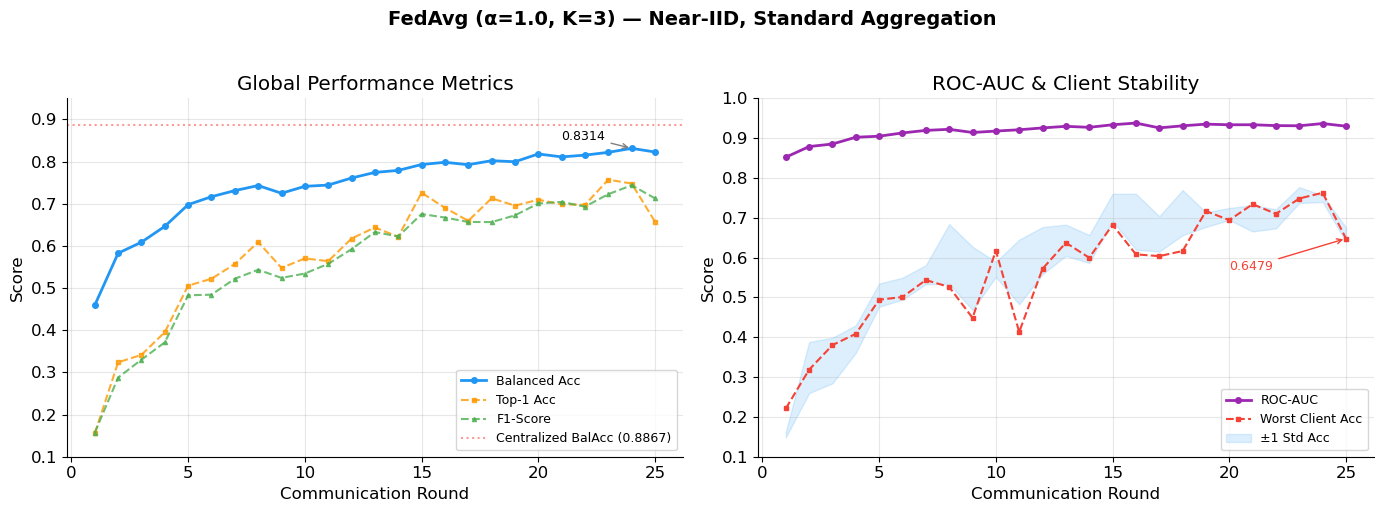

Peak Balanced Accuracy: 0.8314 at Round 24
Final Worst Client Acc: 0.6479 | Final Std Acc: 0.0182


In [16]:
d = fedavg_near_iid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(d['round'], d['bal_acc'], 'o-', color='#2196F3', label='Balanced Acc', linewidth=2, markersize=4)
ax1.plot(d['round'], d['global_acc'], 's--', color='#FF9800', label='Top-1 Acc', linewidth=1.5, markersize=3, alpha=0.8)
ax1.plot(d['round'], d['f1'], '^--', color='#4CAF50', label='F1-Score', linewidth=1.5, markersize=3, alpha=0.8)
ax1.axhline(y=0.8867, color='red', linestyle=':', alpha=0.4, label='Centralized BalAcc (0.8867)')
best_idx = d['bal_acc'].index(max(d['bal_acc']))
ax1.annotate(f'{max(d["bal_acc"]):.4f}', xy=(d['round'][best_idx], max(d['bal_acc'])),
             xytext=(d['round'][best_idx]-3, max(d['bal_acc'])+0.02),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)
ax1.set_xlabel('Communication Round')
ax1.set_ylabel('Score')
ax1.set_title('Global Performance Metrics')
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim(0.1, 0.95)

ax2.plot(d['round'], d['auc'], 'o-', color='#9C27B0', label='ROC-AUC', linewidth=2, markersize=4)
ax2.plot(d['round'], d['worst_acc'], 's--', color='#F44336', label='Worst Client Acc', linewidth=1.5, markersize=3)
worst_final_idx = len(d['worst_acc']) - 1
ax2.annotate(f'{d["worst_acc"][worst_final_idx]:.4f}', xy=(d['round'][worst_final_idx], d['worst_acc'][worst_final_idx]),
             xytext=(d['round'][worst_final_idx]-5, d['worst_acc'][worst_final_idx]-0.08),
             arrowprops=dict(arrowstyle='->', color='#F44336'), fontsize=9, color='#F44336')
ax2.fill_between(d['round'],
                 [a - s for a, s in zip(d['global_acc'], d['std_acc'])],
                 [a + s for a, s in zip(d['global_acc'], d['std_acc'])],
                 alpha=0.15, color='#2196F3', label='±1 Std Acc')
ax2.set_xlabel('Communication Round')
ax2.set_ylabel('Score')
ax2.set_title('ROC-AUC & Client Stability')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_ylim(0.1, 1.0)

fig.suptitle('FedAvg (α=1.0, K=3) — Near-IID, Standard Aggregation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plt.savefig('images/fedavg_near_iid_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Peak Balanced Accuracy: {max(d["bal_acc"]):.4f} at Round {d["round"][best_idx]}')
print(f'Final Worst Client Acc: {d["worst_acc"][-1]:.4f} | Final Std Acc: {d["std_acc"][-1]:.4f}')

---
## Graph 4: SA-Drift (α=0.5, K=5) — Non-IID, Drift-Aware Aggregation

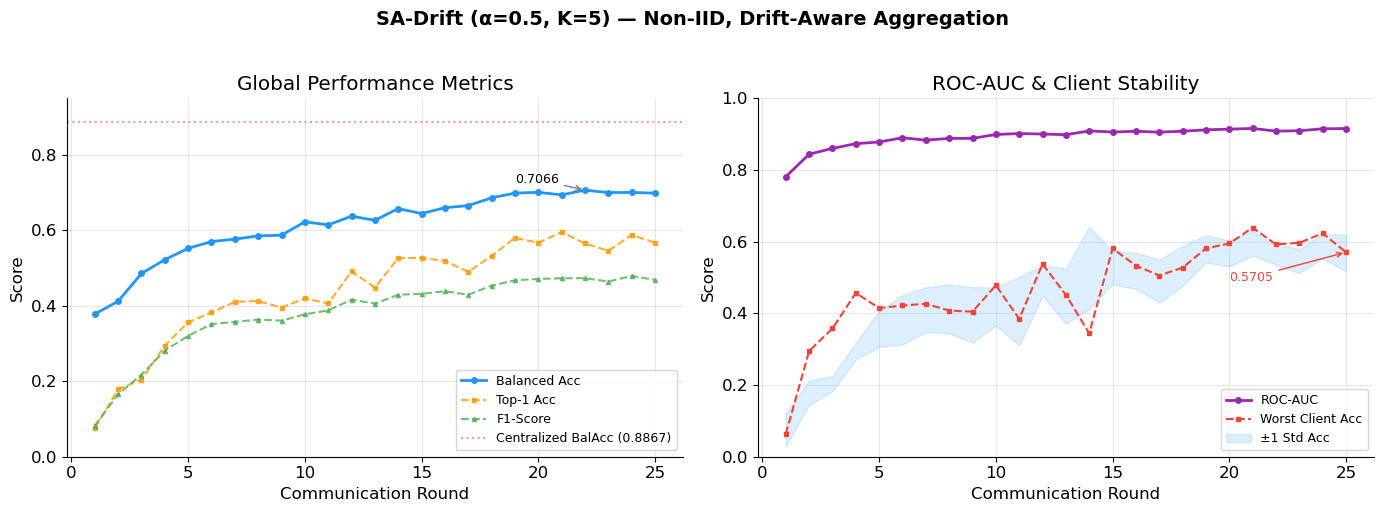

Peak Balanced Accuracy: 0.7066 at Round 22
Final Worst Client Acc: 0.5705 | Final Std Acc: 0.0511


In [17]:
d = sa_drift_non_iid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(d['round'], d['bal_acc'], 'o-', color='#2196F3', label='Balanced Acc', linewidth=2, markersize=4)
ax1.plot(d['round'], d['global_acc'], 's--', color='#FF9800', label='Top-1 Acc', linewidth=1.5, markersize=3, alpha=0.8)
ax1.plot(d['round'], d['f1'], '^--', color='#4CAF50', label='F1-Score', linewidth=1.5, markersize=3, alpha=0.8)
ax1.axhline(y=0.8867, color='red', linestyle=':', alpha=0.4, label='Centralized BalAcc (0.8867)')
best_idx = d['bal_acc'].index(max(d['bal_acc']))
ax1.annotate(f'{max(d["bal_acc"]):.4f}', xy=(d['round'][best_idx], max(d['bal_acc'])),
             xytext=(d['round'][best_idx]-3, max(d['bal_acc'])+0.02),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)
ax1.set_xlabel('Communication Round')
ax1.set_ylabel('Score')
ax1.set_title('Global Performance Metrics')
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim(0.0, 0.95)

ax2.plot(d['round'], d['auc'], 'o-', color='#9C27B0', label='ROC-AUC', linewidth=2, markersize=4)
ax2.plot(d['round'], d['worst_acc'], 's--', color='#F44336', label='Worst Client Acc', linewidth=1.5, markersize=3)
worst_final_idx = len(d['worst_acc']) - 1
ax2.annotate(f'{d["worst_acc"][worst_final_idx]:.4f}', xy=(d['round'][worst_final_idx], d['worst_acc'][worst_final_idx]),
             xytext=(d['round'][worst_final_idx]-5, d['worst_acc'][worst_final_idx]-0.08),
             arrowprops=dict(arrowstyle='->', color='#F44336'), fontsize=9, color='#F44336')
ax2.fill_between(d['round'],
                 [a - s for a, s in zip(d['global_acc'], d['std_acc'])],
                 [a + s for a, s in zip(d['global_acc'], d['std_acc'])],
                 alpha=0.15, color='#2196F3', label='±1 Std Acc')
ax2.set_xlabel('Communication Round')
ax2.set_ylabel('Score')
ax2.set_title('ROC-AUC & Client Stability')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_ylim(0.0, 1.0)

fig.suptitle('SA-Drift (α=0.5, K=5) — Non-IID, Drift-Aware Aggregation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plt.savefig('images/sa_drift_non_iid_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Peak Balanced Accuracy: {max(d["bal_acc"]):.4f} at Round {d["round"][best_idx]}')
print(f'Final Worst Client Acc: {d["worst_acc"][-1]:.4f} | Final Std Acc: {d["std_acc"][-1]:.4f}')

---
## Graph 5: FedAvg (α=0.5, K=5) — Non-IID, Standard Aggregation

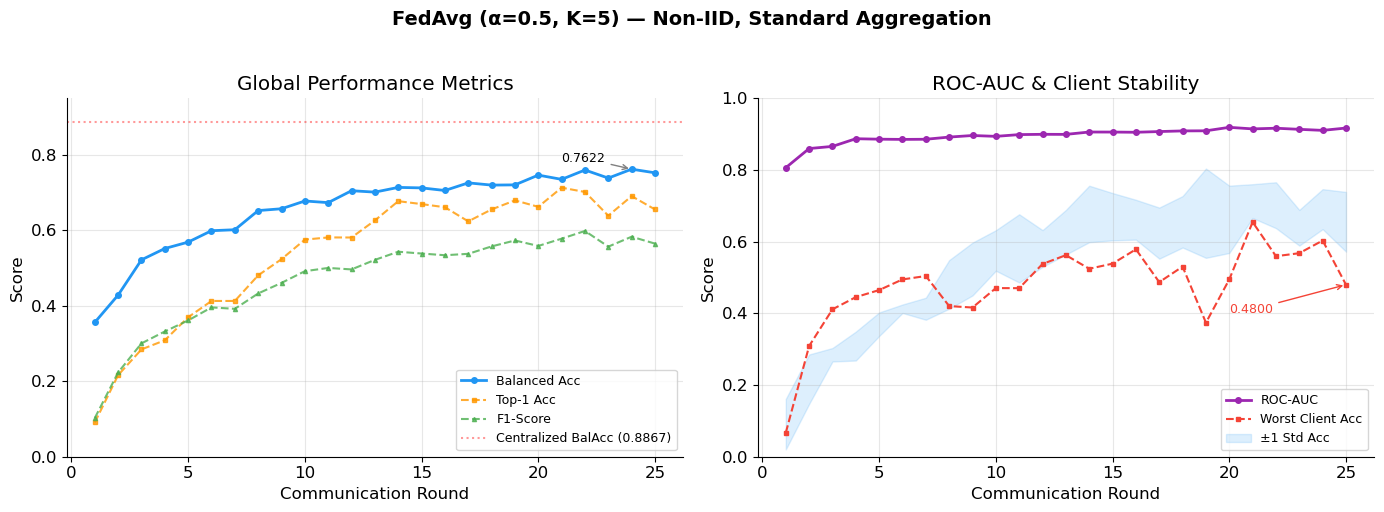

Peak Balanced Accuracy: 0.7622 at Round 24
Final Worst Client Acc: 0.4800 | Final Std Acc: 0.0833


In [18]:
d = fedavg_non_iid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(d['round'], d['bal_acc'], 'o-', color='#2196F3', label='Balanced Acc', linewidth=2, markersize=4)
ax1.plot(d['round'], d['global_acc'], 's--', color='#FF9800', label='Top-1 Acc', linewidth=1.5, markersize=3, alpha=0.8)
ax1.plot(d['round'], d['f1'], '^--', color='#4CAF50', label='F1-Score', linewidth=1.5, markersize=3, alpha=0.8)
ax1.axhline(y=0.8867, color='red', linestyle=':', alpha=0.4, label='Centralized BalAcc (0.8867)')
best_idx = d['bal_acc'].index(max(d['bal_acc']))
ax1.annotate(f'{max(d["bal_acc"]):.4f}', xy=(d['round'][best_idx], max(d['bal_acc'])),
             xytext=(d['round'][best_idx]-3, max(d['bal_acc'])+0.02),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)
ax1.set_xlabel('Communication Round')
ax1.set_ylabel('Score')
ax1.set_title('Global Performance Metrics')
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim(0.0, 0.95)

ax2.plot(d['round'], d['auc'], 'o-', color='#9C27B0', label='ROC-AUC', linewidth=2, markersize=4)
ax2.plot(d['round'], d['worst_acc'], 's--', color='#F44336', label='Worst Client Acc', linewidth=1.5, markersize=3)
worst_final_idx = len(d['worst_acc']) - 1
ax2.annotate(f'{d["worst_acc"][worst_final_idx]:.4f}', xy=(d['round'][worst_final_idx], d['worst_acc'][worst_final_idx]),
             xytext=(d['round'][worst_final_idx]-5, d['worst_acc'][worst_final_idx]-0.08),
             arrowprops=dict(arrowstyle='->', color='#F44336'), fontsize=9, color='#F44336')
ax2.fill_between(d['round'],
                 [a - s for a, s in zip(d['global_acc'], d['std_acc'])],
                 [a + s for a, s in zip(d['global_acc'], d['std_acc'])],
                 alpha=0.15, color='#2196F3', label='±1 Std Acc')
ax2.set_xlabel('Communication Round')
ax2.set_ylabel('Score')
ax2.set_title('ROC-AUC & Client Stability')
ax2.legend(loc='lower right', fontsize=9)
ax2.set_ylim(0.0, 1.0)

fig.suptitle('FedAvg (α=0.5, K=5) — Non-IID, Standard Aggregation', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plt.savefig('images/fedavg_non_iid_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Peak Balanced Accuracy: {max(d["bal_acc"]):.4f} at Round {d["round"][best_idx]}')
print(f'Final Worst Client Acc: {d["worst_acc"][-1]:.4f} | Final Std Acc: {d["std_acc"][-1]:.4f}')

---
## Comparison: All Experiments — Balanced Accuracy

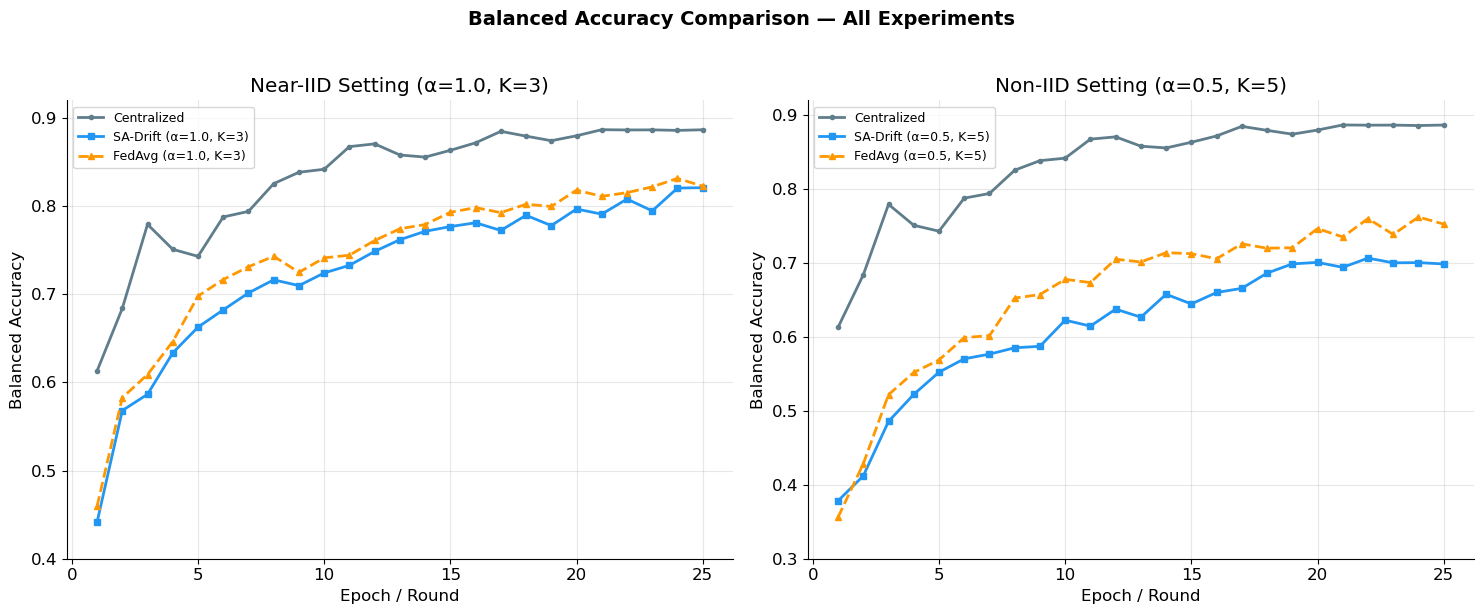

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Near-IID comparison
ax1.plot(centralized['epoch'], centralized['bal_acc'], 'o-', color='#607D8B', label='Centralized', linewidth=2, markersize=3)
ax1.plot(sa_drift_near_iid['round'], sa_drift_near_iid['bal_acc'], 's-', color='#2196F3', label='SA-Drift (α=1.0, K=3)', linewidth=2, markersize=4)
ax1.plot(fedavg_near_iid['round'], fedavg_near_iid['bal_acc'], '^--', color='#FF9800', label='FedAvg (α=1.0, K=3)', linewidth=2, markersize=4)
ax1.set_xlabel('Epoch / Round')
ax1.set_ylabel('Balanced Accuracy')
ax1.set_title('Near-IID Setting (α=1.0, K=3)')
ax1.legend(fontsize=9)
ax1.set_ylim(0.4, 0.92)

# Right: Non-IID comparison
ax2.plot(centralized['epoch'], centralized['bal_acc'], 'o-', color='#607D8B', label='Centralized', linewidth=2, markersize=3)
ax2.plot(sa_drift_non_iid['round'], sa_drift_non_iid['bal_acc'], 's-', color='#2196F3', label='SA-Drift (α=0.5, K=5)', linewidth=2, markersize=4)
ax2.plot(fedavg_non_iid['round'], fedavg_non_iid['bal_acc'], '^--', color='#FF9800', label='FedAvg (α=0.5, K=5)', linewidth=2, markersize=4)
ax2.set_xlabel('Epoch / Round')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_title('Non-IID Setting (α=0.5, K=5)')
ax2.legend(fontsize=9)
ax2.set_ylim(0.3, 0.92)

fig.suptitle('Balanced Accuracy Comparison — All Experiments', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/comparison_balanced_acc.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Summary Table

In [11]:
print('=' * 80)
print(f'{"Experiment":<35} {"Peak BalAcc":>12} {"Final BalAcc":>13} {"Peak AUC":>10}')
print('=' * 80)
print(f'{"Centralized":<35} {max(centralized["bal_acc"]):>12.4f} {centralized["bal_acc"][-1]:>13.4f} {"N/A":>10}')
print(f'{"SA-Drift (α=1.0, K=3)":<35} {max(sa_drift_near_iid["bal_acc"]):>12.4f} {sa_drift_near_iid["bal_acc"][-1]:>13.4f} {max(sa_drift_near_iid["auc"]):>10.4f}')
print(f'{"FedAvg  (α=1.0, K=3)":<35} {max(fedavg_near_iid["bal_acc"]):>12.4f} {fedavg_near_iid["bal_acc"][-1]:>13.4f} {max(fedavg_near_iid["auc"]):>10.4f}')
print(f'{"SA-Drift (α=0.5, K=5)":<35} {max(sa_drift_non_iid["bal_acc"]):>12.4f} {sa_drift_non_iid["bal_acc"][-1]:>13.4f} {max(sa_drift_non_iid["auc"]):>10.4f}')
print(f'{"FedAvg  (α=0.5, K=5)":<35} {max(fedavg_non_iid["bal_acc"]):>12.4f} {fedavg_non_iid["bal_acc"][-1]:>13.4f} {max(fedavg_non_iid["auc"]):>10.4f}')
print('=' * 80)

Experiment                           Peak BalAcc  Final BalAcc   Peak AUC
Centralized                               0.8867        0.8866        N/A
SA-Drift (α=1.0, K=3)                     0.8209        0.8209     0.9398
FedAvg  (α=1.0, K=3)                      0.8314        0.8227     0.9379
SA-Drift (α=0.5, K=5)                     0.7066        0.6987     0.9160
FedAvg  (α=0.5, K=5)                      0.7622        0.7526     0.9191
